# Frank-Wolfe variants for effective attacks on Inception V3 model

### Andrea Sipka, MSc Data Science, University of Padova

* Algorithm source 1: ICLR 2019 submission "A Frank-Wolfe framework for efficient and effective adversarial attacks"
* Algorithm source 2: https://arxiv.org/pdf/1811.10828.pdf

## Background information

**Adversarial image** is an image that tricks an image classifier, but not a human. If you, the human, see an adversarial image of a kitten, it will be obvious to you that the picture contains a kitten, but state-of-the-art image classifier with high accuracy rate, that this image was designed to fool, will misclassify it.

Many different adversarial attacks have been designed in the recent years, due to interest in computer vision, but also image recognition's increasing popularity in the application field - for example, in policing and security.

Adversarial attacks can be **white-box** or **black-box**. In white box attacks, the adversary has access to the target model, and in the black-box setting, the adversary has access to the input and the output of the model, but not model settings.

It's important to point out that the "output" of the model, in the classification task, is a vector of probabilities of an image belonging to each class, rather than just a prediction class.

Adversarial attacks can also be **untargeted** or **targeted**. In an untargeted attack, we simply aim to misclassify the image into any other class, while in the targeted attack, we aim to misclassify an image into a particular class. For example, we might decide that an input image of a "kitten" should be misclassified as a "kitchen sink". As targeted attacks are harder, they are the ones covered in this notebook.

To formulate this as an optimization problem, we let $\ell (\boldsymbol{x}, y)$ be the classification loss function of the deep neural network we are targeting with the attack, where $\boldsymbol{x} \in \Re^d$ is input and $y$ is a corresponding label.

In implementation below, the loss function used is categorical cross entropy, a popular loss function for training neural network to tackle multi-class classification problems. If we let $y_{tar}$ denote the target class of our attack, the function we are trying to minimize is:
$$ f (\boldsymbol{x}) = \ell (\boldsymbol{x}, y_{tar}) $$
subject to the following constraint, where $\boldsymbol{x}_{ori}$ denotes the original input:
$$ || \boldsymbol{x} - \boldsymbol{x}_{ori} ||_p \leq \epsilon $$
The normalization this implementation focuses on is $p = \infty$

## What is this notebook?

This notebook implements a few Frank-Wolfe variants which can be used for adversarial attacks on images.
Description of algorithms and theoretical background can be found in the paper "A Frank-Wolfe framework for efficient and effective adversarial attacks".

In addition to the white and black box implementations from the paper above, I present a modified Frank-Wolfe algorithm with momentum, from the second paper.

The main difference between two papers and the original Frank Wolfe method is as follows:
* Paper 1 (algorithms White box and Black box) calls the linear minimization oracle (which result is denoted by $v_t$ in algorith description) over a more relaxed constraint set $\chi_\lambda = \{ \boldsymbol{x} | || \boldsymbol{x} - \boldsymbol{x}_{ori}||_p \leq \lambda \epsilon \}$ for $\lambda \geq 1 $
* Paper 2 implements the momentum term which nudges the gradient in the direction of the previous step

The notebook is intended to be educational tool. As such, explainability is favoured over performance (hence the use of the notebook). While effort was made to use efficient Python, the efficiency of code can be improved vastly by the use of sessions, GPU processing, and running through Terminal.

Every function in this notebook is docstringed. 
This means that if you want to know what a function (e.g. preprocess_img) does, you do this:

In [ ]:
print(run_classification.__doc__)

In [1]:
import keras
from keras import backend as K
from keras import losses
from keras.applications import inception_v3
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.imagenet_utils import decode_predictions

import matplotlib.pyplot as plt
import numpy as np
import random
import time
import os.path
import os

%matplotlib inline

Using TensorFlow backend.


## Where did the data come from?

Imagenet validation set can be downloaded from Academic torents. However, it doesn't come with labels. The code box below should be ran only once, if you don't have labeled data, as it adds labels to the image names. All of this is mildly infuriating because the way labels are numbered in Keras isn't the same as the way labels are numbered in the actual Imagenet validation.

The following code blob assigns Keras compatible labels to all the files.

val.txt comes from here: http://dl.caffe.berkeleyvision.org/caffe_ilsvrc12.tar.gz

Imagenet validation set torrent can be taken from here: https://academictorrents.com/details/5d6d0df7ed81efd49ca99ea4737e0ae5e3a5f2e5

Once downloaded, data was unzipped into the folder called "imagenetdata".

**Example**
* Orginal file name: "ILSVRC2012_val_00035997.JPEG"
* Original file label: 172
* New file name: "172_ILSVRC2012_val_00035997.JPEG"

In [ ]:
# Get current directory
currentdir = os.getcwd()

# Read in label file
f = open("val.txt","r")
y_val = f.read().strip().split("\n")
y_values = [int(x.split(' ')[1]) for x in y_val]

# Get file names from the folder
file_list = sorted(os.listdir("imagenetdata/"))

# Change the directory
os.chdir("imagenetdata/")

for i, filename in enumerate(file_list):
    # Create new filename by adding label_ to each name
    dst = str(y_values[i])+'_'+filename
    # Actual renaming
    os.rename(filename, dst)
    
# Go back to the original directory
os.chdir(currentdir)

## Load inception model

This will load pre-trained inception model with imagenet weights. If model does not exist, it will be downloaded.

In [2]:
# Load the Inception_V3 model with imagenet weights
inception_model = inception_v3.InceptionV3(weights='imagenet')

Instructions for updating:
Colocations handled automatically by placer.


## Function to use

In [3]:
def preprocess_img(filename):
    """
    Function takes in original image from file passed in,
    and coverts it into a format appropriate to be used with imagenet models
       
    Parameters:
    filename (str): Name of the image file from the imagenetdata folder

    Returns:
    nparray of shape (1, 299, 299, 3) which can be used on inception_v3 model
    """
    
    # load an image in PIL format
    original_image = load_img('imagenetdata/'+filename, target_size=(299, 299))
    
    # convert the PIL image (width, height) to a NumPy array (height, width, channel)
    numpy_image = img_to_array(original_image)
    
    # Convert the image into 4D Tensor (samples, height, width, channels) by adding an extra dimension to the axis 0.
    input_image = np.expand_dims(numpy_image, axis=0)
    
    # Preprocessing required for inception V3
    processed_image_inception_v3 = inception_v3.preprocess_input(input_image.copy())
    
    return processed_image_inception_v3

In [4]:
def generate_target(truelabel):
    """
    Function generates a target label for the attacks.
       
    Parameters:
    truelabel (int): Actual label based on ground truth

    Returns:
    1. nparray of shape 1, 1000 with all 0s and a single 1 for the target label
    2. intiger denoting target class
    """
    
    # Pick a random label other than the actual label
    target_class_index = random.choice(list(range(0, truelabel))+list(range(truelabel+1, 1000)))
    
    # Create an np array with all 0s but the 1 for the label
    target_class = np.zeros((1, 1000))
    target_class[0,target_class_index] = 1.
    
    return target_class_index, target_class

In [5]:
def run_classification(input_img, target_label):
    """
    Function uses the pre-loaded inception model to classify the image passed in
       
    Parameters:
    input_img (np array): Input image to be classified
    target_label (int): Target label for the attack

    Returns:
    1. A boolean that is True if the predicted target is the target class
    2. Integer denoting which class has been predicted
    """    
    
    # Run the model to predict based on pre-processed image
    predictions_inception_v3 = inception_model.predict(input_img)
    
    # Get the predicted label by finding the maximum value
    predicted_label = np.argmax(predictions_inception_v3)
    
    # Evaluate if the target label has been reached by comparing        
    target_reached = (target_label == predicted_label)
    
    return target_reached, predicted_label

In [129]:
# Placeholder variable where fake class comes in
target_class = K.zeros(shape=(1,1000))

# Calculate loss with categorical cross entropy
adversarial_loss = losses.categorical_crossentropy(target_class, inception_model.output) 

# Input image
input_img = inception_model.input 

# Compute gradients with respect to loss
grads = K.gradients(adversarial_loss, input_img)[0]

# Output for the functon
outputs = [grads]

# Function to use during attack
fetch_grads = K.function([input_img, target_class], outputs)

def evaluate_grads(input_img, tgt_class):
    """
    Function uses the keras functions described above to return 
    gradients w.r.t the categorical loss
       
    Parameters:
    input_img (np array): Input image to be classified
    tgt_class (np array): np array for target label

    Returns:
    Gradients of the image w.r.t. the loss
    """ 
    output = fetch_grads([input_img, tgt_class])
    
    return output[0]

In [82]:
# Placeholder variable where fake class comes in
target_class_black = K.zeros(shape=(1,1000))

# Calculate loss with categorical cross entropy
adversarial_loss_black = losses.categorical_crossentropy(target_class_black, inception_model.output) 

# Input image
input_img_black = inception_model.input 

# Output for the functon
outputs_black = [adversarial_loss_black]

# Function to use during attack
fetch_loss = K.function([input_img_black, target_class_black], outputs_black)

def evaluate_loss(input_img, tgt_class):
    """
    Function uses the keras functions described above to return loss
       
    Parameters:
    input_img (np array): Input image to be classified
    tgt_class (np array): np array for target label

    Returns:
    Categorical cross entropy loss
    """ 
    output = fetch_loss([input_img, tgt_class])
    
    return output[0]

In [7]:
def deprocess_image(x):
    """
    Function inverts the processing that was required for modeling.
    Used for display purposes and lifted from Keras examples directory.
       
    Parameters:
    x (np array): Input image to be deprocessed

    Returns:
    Deprocessed image
    """     
    
    x = np.copy(x)
    x = x.reshape((x.shape[1], x.shape[2], 3))
    x /= 2.
    x += 0.5
    x *= 255.
    x = np.clip(x, 0, 255).astype('uint8')
    
    return x

In [8]:
def plot_sidebyside(img1, img2):
    """
    Function that plots two images side by side, and their predicted classes.
       
    Parameters:
    img1 (np array): Input image to be displayed on the left
    img2 (np array): Input image to be displayed on the right
    """ 
    f, axs= plt.subplots(1,2, figsize=(14,20))

    top_predicted_label = inception_v3.decode_predictions(inception_model.predict(img1), top=1)[0][0]
    axs[0].set_title('Predicted: %s (%f)' % (top_predicted_label[1], top_predicted_label[2]))
    axs[0].imshow(deprocess_image(img1))

    top_predicted_label = inception_v3.decode_predictions(inception_model.predict(img2), top=1)[0][0]
    axs[1].set_title('Predicted: %s (%f)' % (top_predicted_label[1], top_predicted_label[2]))
    axs[1].imshow(deprocess_image(img2))

## Attack algorithms

### White box attack with an $L_\infty$ norm.

***
#### Algorithm
- **input:**: number of iterations T, step size $\gamma_t$, $\lambda > 0$, original image $x_{\text{ori}}$
- $x_0 = x_{\text{ori}}$
- **for** $t = 1 ... T$ **do**:
    - $v_t = \text{argmin}_{v \in \chi_\lambda } \langle x, \nabla f(x_t) \rangle$
    - $d_t = v_t - x_t$
    - $x_{t+1} = x_t + \gamma_t d_t$
    - **if** $\lambda > 1$ **then**
        - $x_{t+1} = P_\chi (x_{t+1}) $
- **end for**
- **output:** $x_T$

Note: closed form calculation for $v_t$ is $v_t = - \lambda \cdot \epsilon \cdot \text{sign} (\nabla f(x_t)) + x_{\text{ori}}$

***
Assuming the following hyperparameters (values from the source paper)
* $\lambda = 5$
* Increasing values of $\epsilon$, starting from $\epsilon = 0.001$
* Step size $\gamma = 0.005$


In [192]:
def run_whitebox_attack(img_in, tgt_cl):
    """
    Function performs a targeted white box adversarial attack 
    on an imput image to the class of choice.
    Algorithm used is an adapted Frank-Wolfe.
       
    Parameters:
    img_in (np array): Input image to be classified
    tgt_cl (np array): np array for target label

    Returns:
    1. Original image
    2. New image
    3. Total time the algorithm took
    4. Distortion value
    """ 
    
    x_ori = np.copy(img_in)
    target_class = np.copy(tgt_cl)
    
    epsilon_lambda_todo = np.arange(0.005, 0.5, 0.005)
    gamma_t = 0.005 # stepsize

    # Loop over epsilons from smallest upwards to find the smallest error that yields successful attack
    for epsilon_lambda in epsilon_lambda_todo:
        print('Running epsilon lambda: ', epsilon_lambda)
    
        # ALGORITHM Step 2
        x = np.copy(x_ori)
        
        # ALGORITHM Step 3
        time_start = time.time()
        for iteration in range(1000):
        
            grad_values = evaluate_grads(x, target_class)
        
            target_reached, _ = run_classification(x, targets)
            if target_reached:
                break
                    
            # ALGORITHM Step 4: Linear Minimisation Oracle
            v_t = - epsilon_lambda * np.sign(grad_values) + x_ori
        
            # ALGORITHM Step 5
            d_t = v_t - x
        
            # ALGORITHM Step 6
            x = x + gamma_t * d_t
    
            # ALGORITHM Step 7
            x = x_ori + np.clip((x - x_ori), -(epsilon_lambda), (epsilon_lambda))
    
        if target_reached:
            time_total = time.time() - time_start
            print('Attack successful.')
            distortion = np.max(np.abs(x - x_ori))
            break

    return x_ori, x, time_total, distortion, target_reached

### Black box attack with an $L_\infty$ norm and sampling 

Assuming the following hyperparameters (values from the source paper)
* $\lambda = 30$
* $T = 10000$
* $\epsilon = 0.05$
* $b = 25$
* Step size $\dfrac{0.03}{\sqrt{t}}$, starting from $\gamma = 0.005$, where t is iteration in T
* $\delta = 0.01$

In [149]:
def run_blackbox_attack(img_in, tgt_cl):
    """
    Function performs a black box targeted adversarial attack 
    on an input image to the class of choice.
    Algorithm used is an adapted Frank-Wolfe.
    Zeroth Order gradient estimation is used.
       
    Parameters:
    img_in (np array): Input image to be classified
    tgt_cl (np array): np array for target label

    Returns:
    1. Original image
    2. New image
    3. Total time the algorithm took
    4. Distortion value epsilon times lambda
    """ 
    
    x_ori = np.copy(img_in)
    target_class = np.copy(tgt_cl)
    
    max_queries = 500000
    epsilon = 0.5
    b = 25
    gamma_t = 0.03 #step size
    lmbda = 30
    num_queries = 0

    # ALGORITHM Step 2
    x = np.copy(x_ori)
        
    # ALGORITHM Step 3
    time_start = time.time()
        
    for iteration in range(1 , 10000):
        print('Running iteration: ', iteration)
                        
        target_reached, class_res = run_classification(x, targets)
        
        if target_reached:
            break
        if num_queries > max_queries:
            break
                    
        num_queries += b
                        
        # ALGORITHM Step 4: Linear Minimisation Oracle
        q_t = zero_ord_grad_est(x, target_class)
        
        # STEP SIZE CALCULATION            
        gamma_t = 0.03 / ( iteration**0.5 )
            
        # ALGORITHM step 5
        v_t = - ( epsilon * lmbda * np.sign(q_t) ) + x_ori

        # ALGORITHM step 6
        d_t = v_t - x
            
        # ALGORITHM step 7
        x = x + gamma_t * d_t

        # ALGORITHM step 8-10
        x = x_ori + np.clip((x - x_ori), -(epsilon * lmbda), (epsilon * lmbda))
        
        # Keeping constraints for an image
        x = np.clip(x, 0, 1)
        
    if target_reached:
        time_total = time.time() - time_start
        print('Attack successful')
        distortion = np.max(np.abs(x - x_ori))

    return x_ori, x, time_total, num_queries, distortion, target_reached

In [150]:
def zero_ord_grad_est(x, target_class):
    """
    Function performs a zeroth Order gradient estimation.
       
    Parameters:
    x (np array): Input image
    target_class (np array): np array for target label

    Returns:
    Estimated gradient q
    """ 
    target_class = K.variable(value = target_class, dtype='float64')

    q = 0
    delta_t = 0.01
    
    for i in range(1,26):
        
        multiplier = 1 / (2 * delta_t * i)
        u_i = np.random.standard_normal(x.shape)
        xt_plus =  x + delta_t * u_i
        xt_minus = x - delta_t * u_i
        loss_plus = evaluate_loss(xt_plus, target_class)
        loss_minus = evaluate_loss(xt_minus, target_class)        
        q += q + multiplier * (loss_plus - loss_minus) * u_i
        
    return q

### White box attack with momentum

***
#### Algorithm
- **input:**: number of iterations T, step size $\gamma_t$, original image $x_{\text{ori}}$
- $x_0 = x_{\text{ori}}$ and $m_{-1} = \nabla f (x_o)$
- **for** $t = 1 ... T$ **do**:
    - $m_t = \beta \cdot  m_{t-1} + (1 - \beta) \nabla f (x_t)$
    - $v_t = \text{argmin}_{x \in \chi } \langle x, m_t \rangle$
    - $d_t = v_t - x_t$
    - $x_{t+1} = x_t + \gamma_t d_t$
- **end for**
- **output:** $x_T$

Note: closed form calculation for $v_t$ is $v_t = - \epsilon \cdot \text{sign} (m_t) + x_{\text{ori}}$

***
Implementation bellow assumes the following hyperparameters (values from the source paper)
* Step size $\gamma = 0.1$
* Momentum coefficient $\beta = 0.9$

In [151]:
def run_whitebox_momentum_attack(img_in, tgt_cl):
    """
    Function performs a targeted white box adversarial attack 
    on an input image to the class of choice.
    Algorithm used is an adapted Frank-Wolfe with momentum term
       
    Parameters:
    img_in (np array): Input image to be classified
    tgt_cl (np array): np array for target label

    Returns:
    1. Original image
    2. New image
    3. Total time the algorithm took
    4. Distortion value
    """ 
        
    gamma_t = 0.1 
    beta = 0.9
    epsilon = 0.05

    # ALGORITHM Step 2
    x_ori = np.copy(img_in)
    target_class = np.copy(tgt_cl)
    x = np.copy(x_ori)
    m_t = evaluate_grads(x_ori, target_class)
        
    # ALGORITHM Step 3
    time_start = time.time()
    for iteration in range(10000):
                
        target_reached, _ = run_classification(x, targets)
        
        if target_reached:
            break
                    
        grad_values = evaluate_grads(x, target_class)
        
        # ALGORITHM Step 4
        m_t = beta * m_t + (1-beta) * grad_values
            
        # ALGORITHM Step 5: Linear Minimisation Oracle
        v_t = - epsilon * np.sign(m_t) + x_ori
        
        # ALGORITHM Step 6
        d_t = v_t - x
        
        # ALGORITHM Step 7
        x = x + gamma_t * d_t
    
        # Keeping constraints for an image
        x = np.clip(x, 0, 1)
    
    time_total = time.time() - time_start
    distortion = np.max(np.abs(x - x_ori))
        
    return x_ori, x, time_total, distortion, target_reached

## Choose an image to attack

In [ ]:
# Option 1 : Randomly choose an image
filename = random.choice(os.listdir("imagenetdata/"))

In [187]:
# Option 2: Choose a specific image
filename = '242_ILSVRC2012_val_00031314.JPEG'

## Preprocessing and selecting target

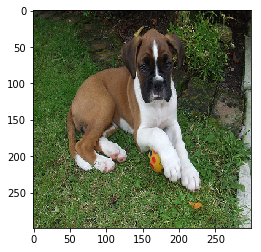

In [188]:
# Preprocess image
processed_image_inception_v3 = preprocess_img(filename)

plt.imshow(deprocess_image(processed_image_inception_v3))

In [179]:
# What is the ground truth label for this image?

truelabel = int(filename[0 : filename.find('_')])
truelabelar = np.zeros((1, 1000))
truelabelar[0,truelabel] = 1.
print('Ground truth Label is %s, class number %i' % (inception_v3.decode_predictions(truelabelar)[0][0][1], truelabel))

# What is the model predicting now?

top_predicted_label = inception_v3.decode_predictions(inception_model.predict(processed_image_inception_v3), top=1)[0][0]
print('Predicted Label is %s, with probability %f' % (top_predicted_label[1], top_predicted_label[2]))

# Has the model got it right?

predicted_correctly, predicted_label  = run_classification(processed_image_inception_v3, truelabel)
print('Predicted correctly?', predicted_correctly )

Ground truth Label is boxer, class number 242
Predicted Label is boxer, with probability 0.948531
Predicted correctly? True


Target Label is anemone_fish, class number 393
Example image:


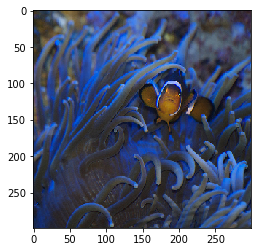

In [183]:
# Generate target randomly

targets, target_class = generate_target(truelabel)
print('Target Label is %s, class number %i' % (inception_v3.decode_predictions(target_class)[0][0][1], targets))

# Show example of the target
filename = [i for i in sorted(os.listdir("imagenetdata/")) if str(targets) == i[0 : i.find('_')]][0]
print('Example image:')
plt.imshow(deprocess_image(preprocess_img(filename)))

## White box attack example

In [ ]:
original_image, new_image, time_took, distortion, targetreached = run_whitebox_attack(processed_image_inception_v3, target_class)

print('Attack successful?', targetreached)
print('--- distortion = ', distortion)
print("--- attack time: ",time_took,"seconds")
# Display image now and see how it is classified
plot_sidebyside(original_image, new_image)

Running epsilon lambda:  0.005


## White box attack example (with momentum)

Attack successful? True
--- distortion =  1.0
--- attack time:  2.4626429080963135 seconds


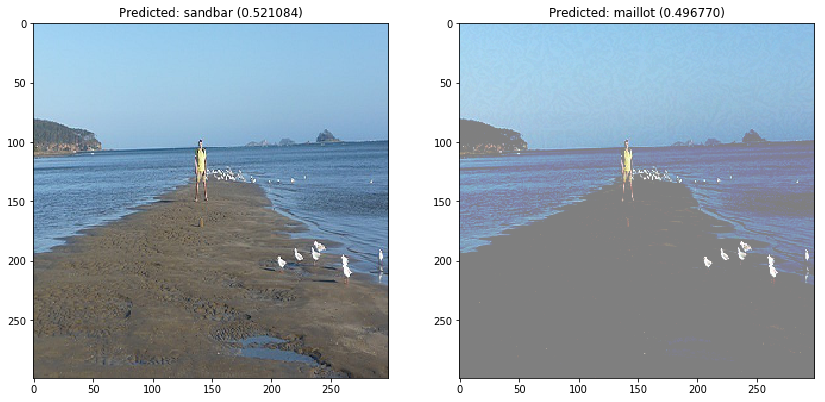

In [175]:
original_image, new_image, time_took, distortion, targetreached = run_whitebox_momentum_attack(processed_image_inception_v3, target_class)

print('Attack successful?', targetreached)
print('--- distortion = ', distortion)
print("--- attack time: ",time_took,"seconds")
# Display image now and see how it is classified
plot_sidebyside(original_image, new_image)

## Black box attack example

In [128]:
original_image, new_image, time_took, total_queres, distortion = run_blackbox_attack(processed_image_inception_v3, target_class)

print('Attack successful with distortion = ', distortion)
print("Attack time: ",time_took,"seconds.")

# Display image now and see how it is classified
plot_sidebyside(original_image, new_image)

Running iteration:  1
242 0.1
Running iteration:  2
217 0.03
Running iteration:  3
164 0.021213203435596423
Running iteration:  4
801 0.017320508075688773
Running iteration:  5
2 0.015
Running iteration:  6
2 0.013416407864998738
Running iteration:  7
2 0.012247448713915891
Running iteration:  8
974 0.011338934190276815
Running iteration:  9
974 0.010606601717798212
Running iteration:  10
701 0.01
Running iteration:  11
107 0.009486832980505138
Running iteration:  12
111 0.009045340337332909
Running iteration:  13
701 0.008660254037844387
Running iteration:  14
701 0.008320502943378437
Running iteration:  15
701 0.00801783725737273
Running iteration:  16
701 0.007745966692414833
Running iteration:  17
974 0.0075
Running iteration:  18
701 0.007276068751089989
Running iteration:  19
974 0.007071067811865475
Running iteration:  20
701 0.006882472016116852
Running iteration:  21
21 0.006708203932499369
Running iteration:  22
701 0.006546536707079772
Running iteration:  23
21 0.00639602149

KeyboardInterrupt: 

## Run experiment

In [153]:
result_list = []

In [154]:
for experiment in range(0,20):
    print('            Running experiment: ', experiment)
    
    # Option 1 : Randomly choose an image
    filename = random.choice(os.listdir("imagenetdata/"))
    
    # Preprocess image
    processed_image_inception_v3 = preprocess_img(filename)

    # What is the ground truth label for this image?
    truelabel = int(filename[0 : filename.find('_')])
    truelabelar = np.zeros((1, 1000))
    truelabelar[0,truelabel] = 1.
    print('     Ground truth Label is %s, class number %i' % (inception_v3.decode_predictions(truelabelar)[0][0][1], truelabel))
    
    # What is the model predicting now?
    top_predicted_label = inception_v3.decode_predictions(inception_model.predict(processed_image_inception_v3), top=1)[0][0]
    print('     Predicted Label is %s, with probability %f' % (top_predicted_label[1], top_predicted_label[2]))

    # Has the model got it right?
    predicted_correctly, predicted_label  = run_classification(processed_image_inception_v3, truelabel)
    print('     Predicted correctly?', predicted_correctly )
    # Generate target randomly

    targets, target_class = generate_target(truelabel)
    print('     Target Label is %s, class number %i' % (inception_v3.decode_predictions(target_class)[0][0][1], targets))
        
    # White box attack
    original_image, new_image, time_took, distortion, targetreached = run_whitebox_attack(processed_image_inception_v3, target_class)
    print('      White box attack successful with distortion = ', distortion)
    print("      Attack time: ",time_took,"seconds.")
    
    # Momentum attack
    original_image_m, new_image_m, time_took_m, distortion_m, targetreached_m = run_whitebox_momentum_attack(processed_image_inception_v3, target_class)
    print('      White box with momentum attack successful with distortion = ', distortion_m)
    print("      Attack time: ",time_took_m,"seconds.")
    
    result_list.append([experiment, filename, truelabel, targets, time_took, distortion, targetreached, new_image, time_took_m, distortion_m, targetreached_m, new_image_m])

            Running experiment:  0
     Ground truth Label is porcupine, class number 334
     Predicted Label is porcupine, with probability 0.998749
     Predicted correctly? True
     Target Label is African_hunting_dog, class number 275
Running epsilon lambda:  0.25
Attack successful.
      White box attack successful with distortion =  1.0
      Attack time:  3.8153188228607178 seconds.
      White box with momentum attack successful with distortion =  1.0
      Attack time:  2.959962844848633 seconds.
            Running experiment:  1
     Ground truth Label is soup_bowl, class number 809
     Predicted Label is soup_bowl, with probability 0.812355
     Predicted correctly? True
     Target Label is comic_book, class number 917
Running epsilon lambda:  0.25
Attack successful.
      White box attack successful with distortion =  1.0
      Attack time:  7.056896924972534 seconds.
      White box with momentum attack successful with distortion =  1.0
      Attack time:  6.286235094

     Predicted correctly? True
     Target Label is trailer_truck, class number 867
Running epsilon lambda:  0.25
Attack successful.
      White box attack successful with distortion =  1.0
      Attack time:  5.339830160140991 seconds.
      White box with momentum attack successful with distortion =  1.0
      Attack time:  4.663640737533569 seconds.
            Running experiment:  17
     Ground truth Label is pill_bottle, class number 720
     Predicted Label is pill_bottle, with probability 0.991430
     Predicted correctly? True
     Target Label is amphibian, class number 408
Running epsilon lambda:  0.25
Attack successful.
      White box attack successful with distortion =  1.0
      Attack time:  4.844554901123047 seconds.
      White box with momentum attack successful with distortion =  1.0
      Attack time:  6.734073162078857 seconds.
            Running experiment:  18
     Ground truth Label is barber_chair, class number 423
     Predicted Label is barber_chair, with p

In [159]:
import pandas as pd

resultdf = pd.DataFrame(result_list, columns=['experiment_id', 'target_image','label','target','white_box_time','white_box_distortion', 'whitebox_sucessful', 'whitebox_img','momentum_time','momentum_distortion', 'momentum_successful', 'momentum_'])


,experiment_id,target_image,label,target,white_box_time,white_box_distortion,whitebox_sucessful,whitebox_img,momentum_time,momentum_distortion,momentum_successful,momentum_
0,0,334_ILSVRC2012_val_00044340.JPEG,334,275,3.815319,1.000000,True,"[[[[0.06251749 0. 0. ], [0.0105...",2.959963,1.000000,True,"[[[[0.03539564 0. 0. ], [0.0061..."
1,1,809_ILSVRC2012_val_00040184.JPEG,809,917,7.056897,1.000000,True,"[[[[1. 0.9965069 0.99528587], [1. 1. ...",6.286235,1.000000,True,"[[[[1. 1. 0.9641215], [0.9985114..."
2,2,797_ILSVRC2012_val_00040462.JPEG,797,922,5.235962,1.000000,True,"[[[[0.12694307 0.7930568 0.99759865], [0.0328...",8.611113,1.000000,True,"[[[[0.13358344 0.8267969 0.9614384 ], [0. ..."
3,3,977_ILSVRC2012_val_00036544.JPEG,977,108,3.032840,1.000000,True,[[[[1.3235211e-04 1.9628729e-01 7.7912986e-01]...,2.062326,1.000000,True,"[[[[0. 0.18280505 0.7975872 ], [0. ..."
4,4,388_ILSVRC2012_val_00044876.JPEG,388,426,9.401585,1.000000,True,"[[[[0. 0. 0.], [0. 0. 0.], [0. 0. 0.], [0. 0. ...",5.438731,1.000000,True,"[[[[0. 0. 0.], [0. 0. 0.], [0. 0. 0.], [0. 0. ..."
5,5,801_ILSVRC2012_val_00003710.JPEG,801,568,6.214399,0.984314,True,"[[[[0.8601404 0.8595636 0.91240865], [0.8782...",3.179721,0.984314,True,"[[[[0.8353955 0.8275524 0.9371535], [0.8510818..."
6,6,444_ILSVRC2012_val_00018975.JPEG,444,912,7.732026,1.000000,True,"[[[[0.9305522 0.93599355 0.9589834 ], [0.9305...",6.018420,1.000000,True,"[[[[0.96197784 0.969821 0.9576513 ], [0.9619..."
7,7,125_ILSVRC2012_val_00000245.JPEG,125,640,6.345981,1.000000,True,"[[[[0. 0. 0.], [0. 0. 0.], [0. 0. 0.], [0. 0. ...",4.140182,1.000000,True,"[[[[0. 0. 0.], [0. 0. 0.], [0. 0. 0.], [0. 0. ..."
8,8,212_ILSVRC2012_val_00001992.JPEG,212,15,15.300866,1.000000,True,"[[[[0. 0. 0.], [0. 0. 0.], [0. 0. 0.], [0. 0. ...",10.989015,1.000000,True,"[[[[0. 0. 0.], [0. 0. 0.], [0. 0. 0.], [0. 0. ..."
9,9,901_ILSVRC2012_val_00003972.JPEG,901,529,6.113928,1.000000,True,"[[[[0.00810755 0.00270511 0.00017157], [0.0227...",3.470685,1.000000,True,"[[[[0.03784992 0. 0. ], [0.0378..."


In [165]:
result_small = resultdf[['experiment_id', 'target_image','label','target','white_box_time',
                         'white_box_distortion', 'whitebox_sucessful','momentum_time',
                         'momentum_distortion', 'momentum_successful']]

In [166]:
result_small

,experiment_id,target_image,label,target,white_box_time,white_box_distortion,whitebox_sucessful,momentum_time,momentum_distortion,momentum_successful
0,0,334_ILSVRC2012_val_00044340.JPEG,334,275,3.815319,1.000000,True,2.959963,1.000000,True
1,1,809_ILSVRC2012_val_00040184.JPEG,809,917,7.056897,1.000000,True,6.286235,1.000000,True
2,2,797_ILSVRC2012_val_00040462.JPEG,797,922,5.235962,1.000000,True,8.611113,1.000000,True
3,3,977_ILSVRC2012_val_00036544.JPEG,977,108,3.032840,1.000000,True,2.062326,1.000000,True
4,4,388_ILSVRC2012_val_00044876.JPEG,388,426,9.401585,1.000000,True,5.438731,1.000000,True
5,5,801_ILSVRC2012_val_00003710.JPEG,801,568,6.214399,0.984314,True,3.179721,0.984314,True
6,6,444_ILSVRC2012_val_00018975.JPEG,444,912,7.732026,1.000000,True,6.018420,1.000000,True
7,7,125_ILSVRC2012_val_00000245.JPEG,125,640,6.345981,1.000000,True,4.140182,1.000000,True
8,8,212_ILSVRC2012_val_00001992.JPEG,212,15,15.300866,1.000000,True,10.989015,1.000000,True
9,9,901_ILSVRC2012_val_00003972.JPEG,901,529,6.113928,1.000000,True,3.470685,1.000000,True
